In [1]:
# Copyright 2024 Keysight Technologies Inc.

In [2]:
import trueq as tq
from trueq.simulation.noise_source import NoiseSource

# create circuits for crosstalk diagnostics on qubits 5, 6, and 7 for single-qubit gates
circuits = tq.make_crosstalk_diagnostics([5, 6, 7], [4, 16, 32], 50)

In [3]:
class CrossTalk(NoiseSource):
    # this is a simple crosstalk simulator (not based on realistic device physics),
    # where adjacent qubits add a fraction of their own gate to the other qubit
    def __init__(self, rotations, match=None):
        self.rotations = rotations
        super().__init__(match=match)

    def make_circuit_cache(self, circuit):
        return circuit.labels

    def apply(self, cycle_wrappers, backend, circuit_cache):
        for labels, gate in self.match.iter_gates(cycle_wrappers, noise_only=False):
            for label in circuit_cache:
                if abs(label - labels[0]) == 1:
                    # if qubit labels are 1 apart, multiply the other qubit by a small
                    # fraction of this qubit's gate
                    backend.process_gate(labels, (gate ** self.rotations[labels[0]]))
                elif label == labels[0]:
                    # simulate the entire gate on this qubit
                    backend.process_gate(labels, gate)


cycle_crosstalk = CrossTalk(rotations={5: 0.01, 6: 0.045, 7: 0.03})
sim = tq.Simulator().add_stochastic_pauli(pz=0.02)
sim.append_noise_source(cycle_crosstalk)
sim.run(circuits)

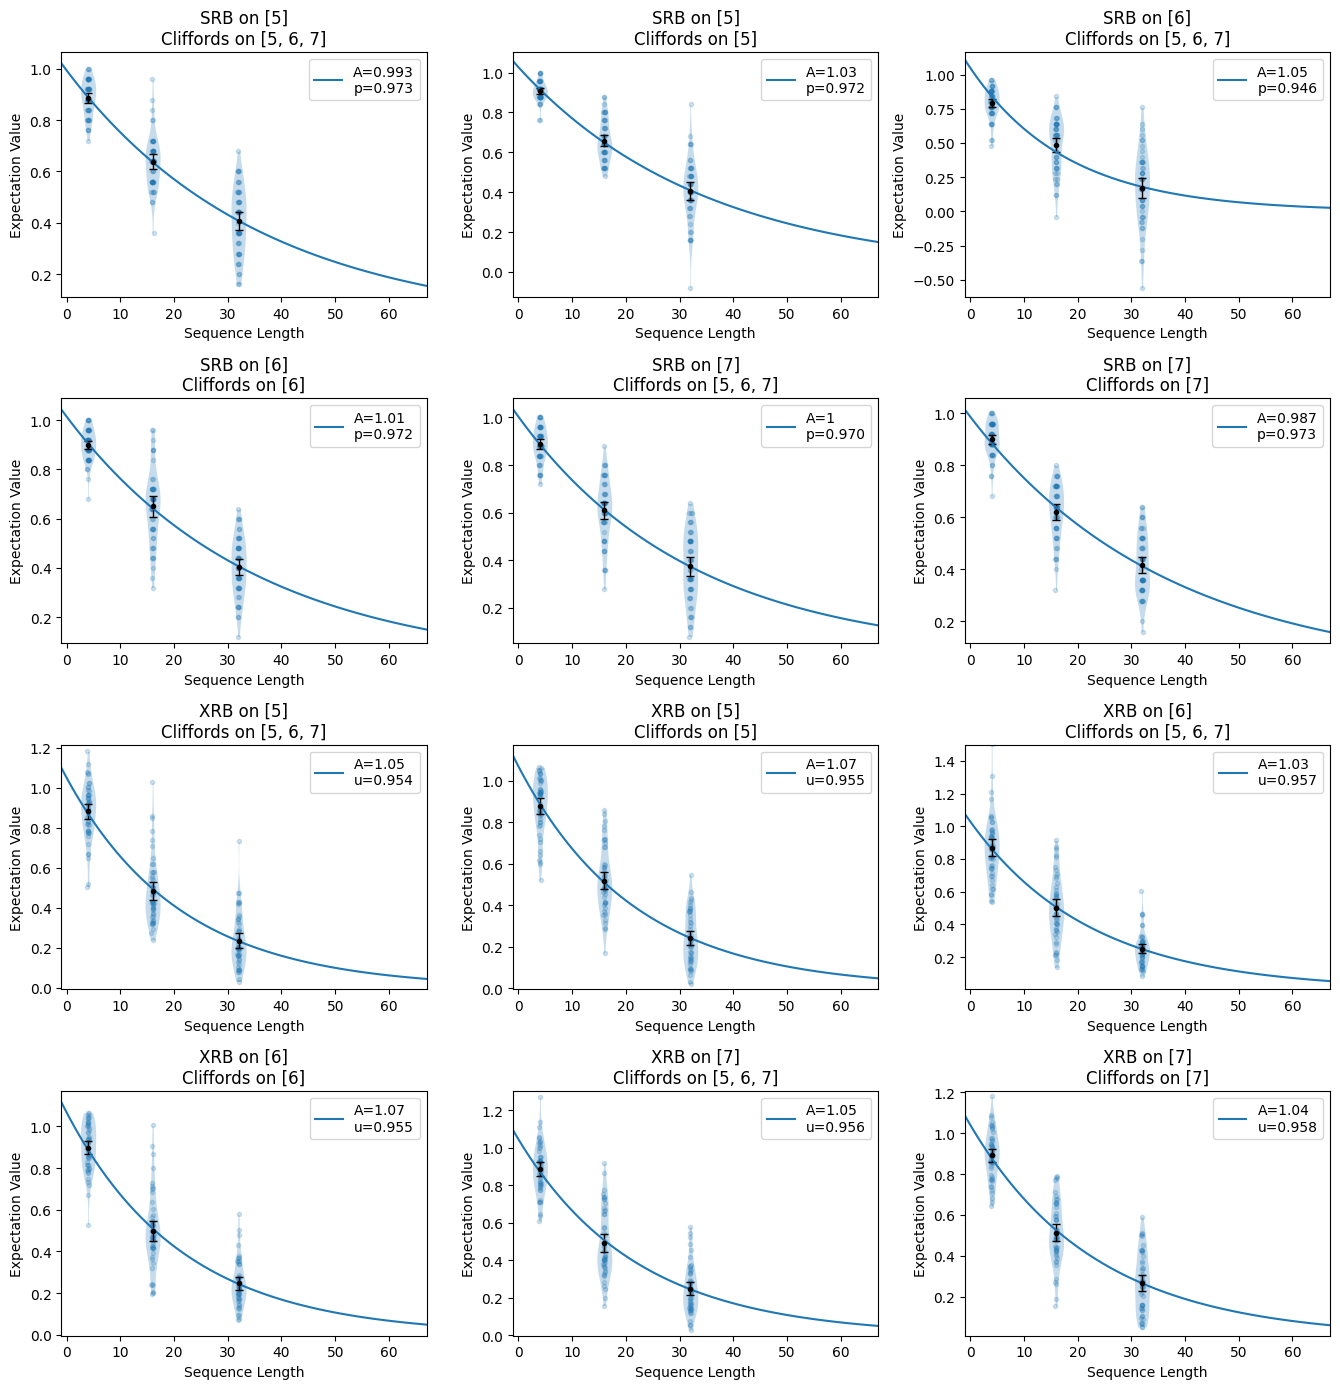

In [4]:
circuits.plot.raw()

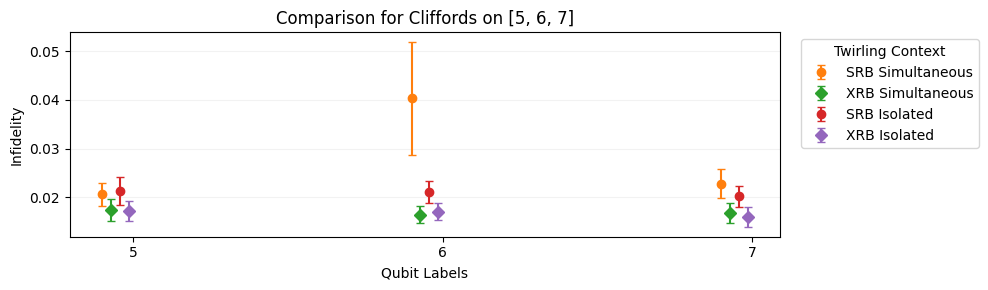

In [5]:
circuits.plot.compare_rb()